In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import zipfile
import json
import os
import time

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

base_dir = "/home/fsuser/" # install git repo in this directory
repo_dir = base_dir + "de-identification/"

data_path = repo_dir+"downloaded-data/"

Random Seed:  999


In [3]:
# Root directory for dataset
dataroot = data_path+ 'img_align_celeba/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64 # use 128 but only generates central 64x64
border = image_size//4

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

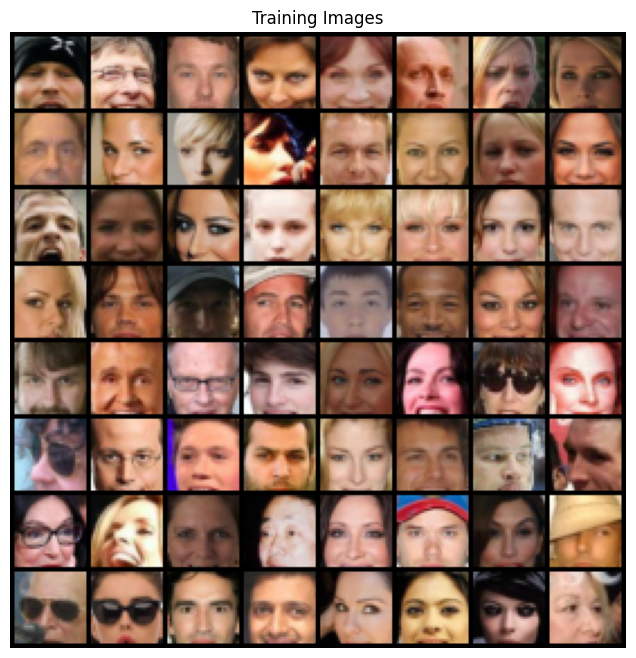

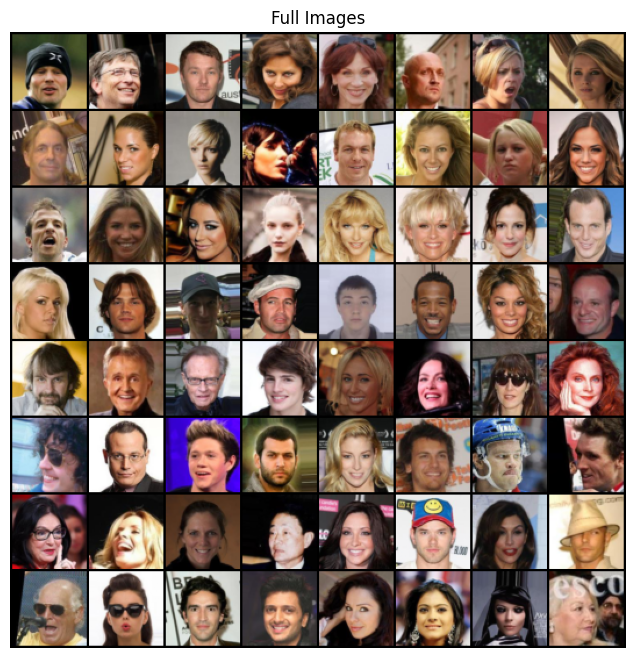

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:, :, border:-border, border:-border].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Full Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
noise = torch.randn(64, nz, 1, 1, device=device)

In [7]:
#load models
models_dir = repo_dir + "pretrained-models/"
version = 'original-10-epochs' # need 
netG_loaded = Generator(ngpu).to(device)
netG_loaded.load_state_dict(torch.load(models_dir + f"DCGAN-{version}-netG.pth"))
netG_loaded.eval()

netD_loaded = Discriminator(ngpu).to(device)
netD_loaded.load_state_dict(torch.load(models_dir + f"DCGAN-{version}-netD.pth"))
netD_loaded.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

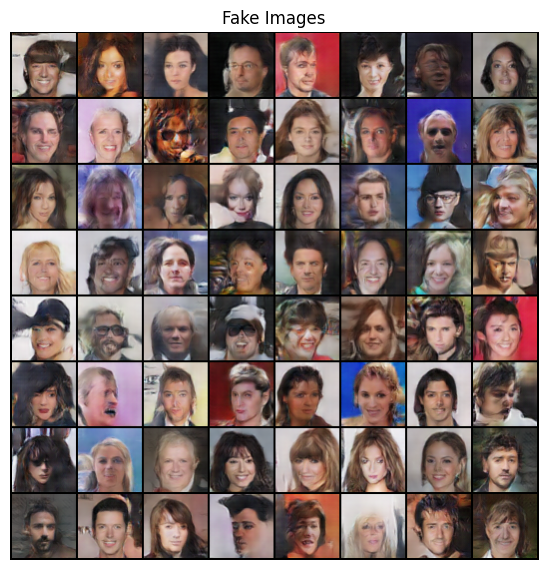

In [8]:
with torch.no_grad():
    fake = netG_loaded(noise).detach().cpu()
grid = vutils.make_grid(fake, padding=2, normalize=True)

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(grid,(1,2,0)))
plt.show()

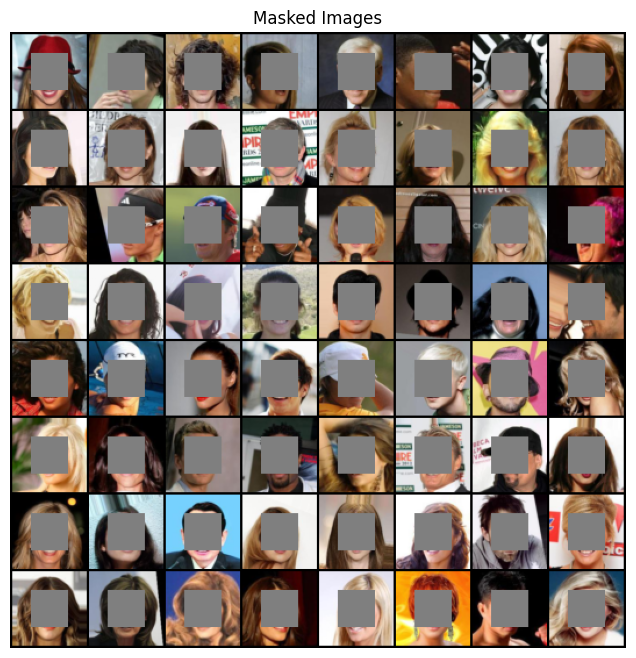

In [9]:
mask = torch.ones((1, 3, image_size, image_size)).to(device)
mask[:, :, border:-border, border:-border] = 0

real_batch = next(iter(dataloader))
images = real_batch[0].to(device)[:64]
masked_images = images*mask
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Masked Images")
plt.imshow(np.transpose(vutils.make_grid(masked_images[:64], padding=2, normalize=True).cpu(),(1,2,0)))

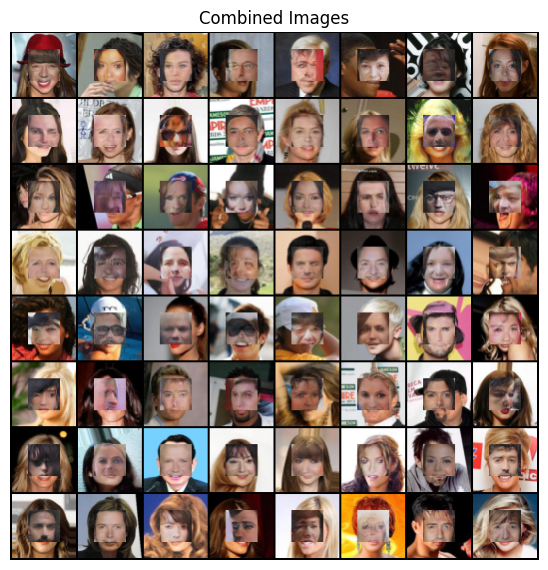

In [10]:
combined_images = masked_images.clone()
combined_images[:, :, border:-border, border:-border] = fake[:, :, border:-border, border:-border]
plt.figure(figsize=(15,15))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Combined Images")
plt.imshow(np.transpose(vutils.make_grid(combined_images, padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
def display_img(matrix, title = None):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,2)
    plt.axis("off")
    if title is not None: plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(matrix, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()
# display_img((generated*mask).detach().cpu())
# display_img((images*mask).detach().cpu())

In [12]:
real_batch = next(iter(dataloader))[0].to(device)

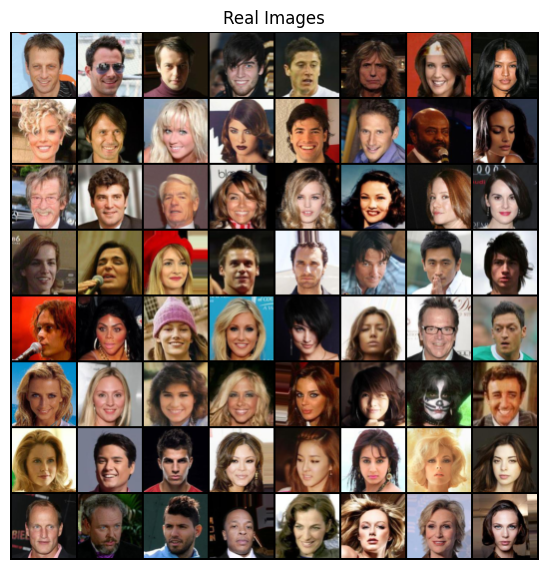

In [13]:
display_img(real_batch[:64], "Real Images")

In [14]:
criterion = nn.BCELoss()
lam = 0.1 # perceptual_loss factor

In [15]:
images = real_batch[:1]

zhats = torch.randn(images.shape[0], nz, 1, 1, device=device).requires_grad_()
mask = torch.ones((1, 3, image_size, image_size)).to(device)
mask[:, :, border:-border, border:-border] = 0
results = [netG_loaded(zhats)[0].clone()]

lr = 0.0002
iterations = 10000
eval_interval = 200


optimizer = optim.Adam([zhats], lr=lr)
t_start = time.time()
for i in range(iterations):
    generated = netG_loaded(zhats)
    contextual_loss = nn.functional.l1_loss(mask*generated, mask*images) # keep outside obscured region the same

    real_label = torch.full((images.shape[0],), 1., dtype=torch.float, device=device)
    output = netD_loaded(generated.detach()).view(-1)
    perceptual_loss = criterion(output, real_label) #g_loss

    complete_loss = contextual_loss + lam*perceptual_loss
    optimizer.zero_grad()
    complete_loss.backward()
    optimizer.step()

    if i % eval_interval == eval_interval-1:
        print(f"i: {i} Losses:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
        results.append(generated[0].clone())


Losses:: Complete:0.6374, contextual:0.4275, perceptual:0.2099 (after x0.1), time: 1.12s
Losses:: Complete:0.6476, contextual:0.3920, perceptual:0.2557 (after x0.1), time: 1.73s
Losses:: Complete:0.6595, contextual:0.3676, perceptual:0.2919 (after x0.1), time: 2.67s
Losses:: Complete:0.6482, contextual:0.3491, perceptual:0.2992 (after x0.1), time: 3.85s
Losses:: Complete:0.6302, contextual:0.3357, perceptual:0.2944 (after x0.1), time: 4.83s
Losses:: Complete:0.6147, contextual:0.3245, perceptual:0.2902 (after x0.1), time: 5.57s
Losses:: Complete:0.5852, contextual:0.3137, perceptual:0.2715 (after x0.1), time: 6.55s
Losses:: Complete:0.5741, contextual:0.3056, perceptual:0.2685 (after x0.1), time: 7.57s
Losses:: Complete:0.5765, contextual:0.2976, perceptual:0.2788 (after x0.1), time: 8.43s
Losses:: Complete:0.5742, contextual:0.2897, perceptual:0.2845 (after x0.1), time: 9.12s
Losses:: Complete:0.5409, contextual:0.2804, perceptual:0.2605 (after x0.1), time: 9.74s
Losses:: Complete:0.5

torch.Size([53, 3, 64, 64]) torch.Size([52, 3, 64, 64])


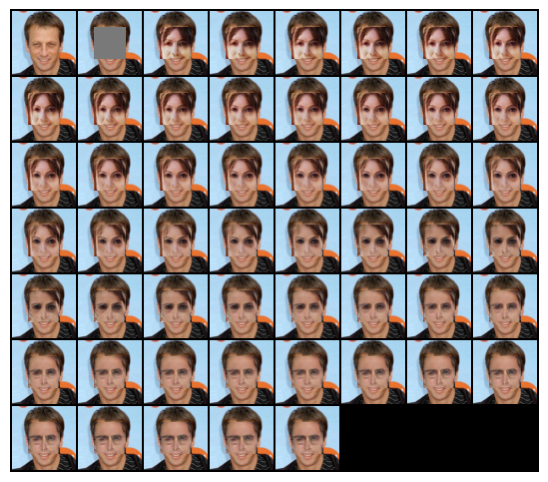

In [16]:
original_image = images[0].clone()
display_output = torch.stack([(mask*original_image)[0]] + results, dim=0)
original_image_stack = torch.stack([original_image]*(len(results)+2), dim=0)
print(original_image_stack.shape, display_output.shape)
original_image_stack[1:, :, border:-border, border:-border] = display_output[:, :, border:-border, border:-border]
display_img(original_image_stack)

In [19]:
# generate gif
import imageio
images = []
for i in range(original_image_stack.shape[0]):
    output = original_image_stack[i].clone()
    normalized = vutils.make_grid(output, padding=2, normalize=True).cpu().permute(1,2,0).numpy()
    normalized = normalized*255
    normalized = normalized.astype(np.uint8)
    images.append(normalized)
gif_name = "10-epochs-gan-fast"
imageio.mimsave(f'media/{gif_name}.gif', images, duration=0.2)